<a href="https://colab.research.google.com/github/mohamedalaaaz/testpytroch/blob/main/Wave%20Propagation%20with%20Energy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

propagation—and that it should include graphs and be written in an advanced style.

Let's assume you're interested in simulating energy propagation using something like a wave equation, which is a classic example in physics. We’ll use PyTorch to:

Simulate the wave equation in 1D or 2D.

Track energy propagation over time.

Plot the results using matplotlib.

This example uses the 1D wave equation:

∂
2
𝑢
∂
𝑡
2
=
𝑐
2
∂
2
𝑢
∂
𝑥
2
∂t
2
∂
2
u
	​

=c
2
∂x
2
∂
2
u
	​


Where:

𝑢
(
𝑥
,
𝑡
)
u(x,t): wave function.

𝑐
c: wave speed.

We’ll use finite differences and PyTorch tensors for computation and autodiff if needed.

🔬 Advanced PyTorch Physics Simulation: 1D Wave Propagation with Energy Graphs
✅ Features:

1D wave propagation using the wave equation.

Energy computation at each time step.

Plot of wave and energy over time.

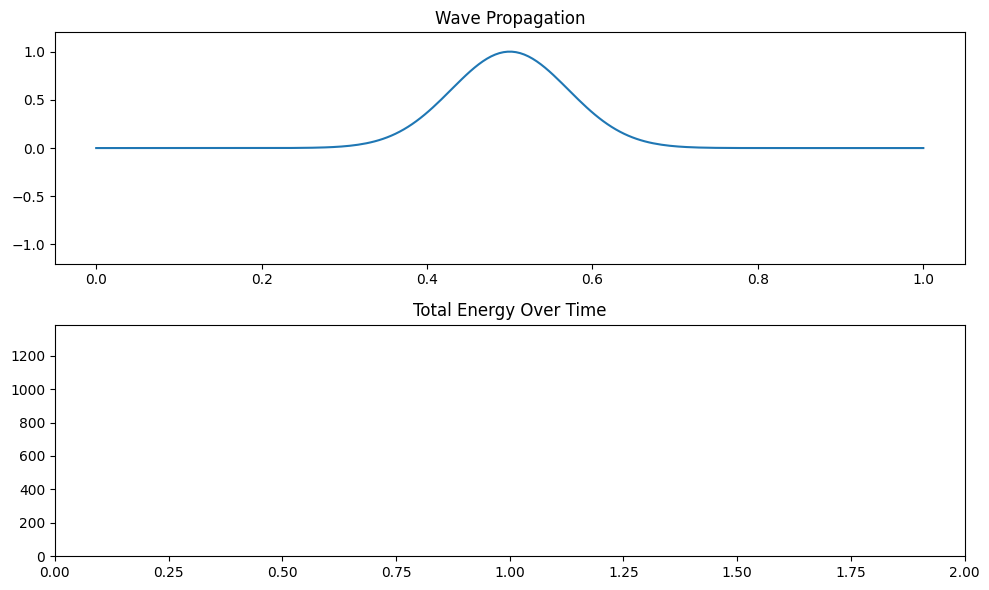

In [2]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
L = 1.0               # Length of the string
Nx = 200              # Number of spatial points
dx = L / Nx           # Spatial step
c = 1.0               # Wave speed
dt = 0.001            # Time step
T = 2.0               # Total time
Nt = int(T / dt)      # Number of time steps

# CFL condition for stability: c * dt / dx <= 1
assert c * dt / dx <= 1.0, "CFL condition not met!"

# Spatial grid
x = torch.linspace(0, L, Nx, device=device)

# Initialize wave: u(x, 0) = exp(-100 * (x - 0.5)^2)
u0 = torch.exp(-100 * (x - 0.5) ** 2)
u1 = u0.clone()

# Prepare second time step using wave equation
u2 = torch.zeros_like(u0)

# Store history
history = [u0.cpu().numpy()]
energy_history = []

# Helper: Compute energy (kinetic + potential)
def compute_energy(u_prev, u_curr):
    kinetic = ((u_curr - u_prev) / dt) ** 2
    potential = ((torch.roll(u_curr, -1) - 2 * u_curr + torch.roll(u_curr, 1)) / dx ** 2)
    potential *= c ** 2
    energy_density = 0.5 * (kinetic + potential)
    return energy_density.sum().item()

# Time evolution
for n in range(Nt):
    u2[1:-1] = 2 * u1[1:-1] - u0[1:-1] + c**2 * dt**2 / dx**2 * (u1[2:] - 2*u1[1:-1] + u1[:-2])

    # Apply boundary conditions: u = 0 at boundaries (Dirichlet)
    u2[0] = u2[-1] = 0.0

    # Store and update
    energy = compute_energy(u0, u1)
    energy_history.append(energy)
    if n % 10 == 0:
        history.append(u1.cpu().numpy())

    u0, u1 = u1, u2.clone()

# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
line1, = ax1.plot(x.cpu(), history[0])
ax1.set_ylim(-1.2, 1.2)
ax1.set_title("Wave Propagation")

line2, = ax2.plot([], [], color='red')
ax2.set_xlim(0, T)
ax2.set_ylim(0, max(energy_history) * 1.1)
ax2.set_title("Total Energy Over Time")

def animate(i):
    line1.set_ydata(history[i])
    line2.set_data(torch.arange(0, len(energy_history[:i*10]), 1) * dt, energy_history[:i*10])
    return line1, line2

ani = FuncAnimation(fig, animate, frames=len(history), interval=30, blit=True)
plt.tight_layout()
plt.show()


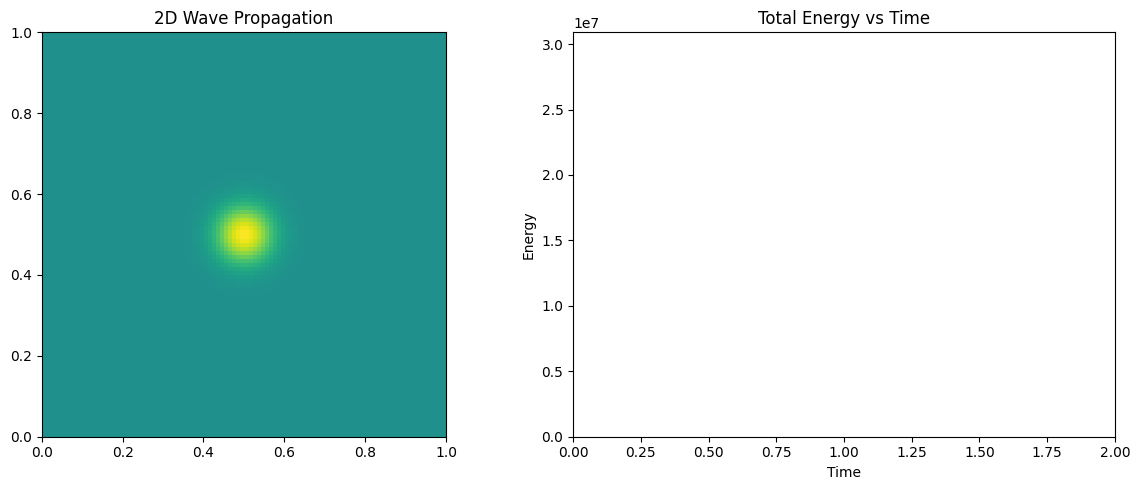

In [3]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Simulation parameters
Nx, Ny = 100, 100      # Grid size
Lx, Ly = 1.0, 1.0      # Physical size
dx, dy = Lx / Nx, Ly / Ny
dt = 0.001
T = 2.0
Nt = int(T / dt)
c = 1.0                # Wave speed
damping = 0.0005       # Damping factor

# Stability condition (2D CFL)
assert c * dt / min(dx, dy) <= 1.0, "CFL condition not met!"

# Grid
x = torch.linspace(0, Lx, Nx, device=device)
y = torch.linspace(0, Ly, Ny, device=device)
X, Y = torch.meshgrid(x, y, indexing='ij')

# Initial conditions: Gaussian in center
u0 = torch.exp(-200 * ((X - 0.5)**2 + (Y - 0.5)**2)).to(device)
u1 = u0.clone()
u2 = torch.zeros_like(u0)

# History
history = [u0.cpu().numpy()]
energy_history = []

def laplacian(U):
    return (
        -4 * U
        + torch.roll(U, 1, 0) + torch.roll(U, -1, 0)
        + torch.roll(U, 1, 1) + torch.roll(U, -1, 1)
    ) / dx**2

def compute_energy(u_prev, u_curr):
    kinetic = ((u_curr - u_prev) / dt) ** 2
    potential = c**2 * (laplacian(u_curr))**2
    total_energy = 0.5 * (kinetic + potential)
    return total_energy.sum().item()

# Time stepping
for n in range(Nt):
    lap_u1 = laplacian(u1)
    u2 = (
        (2 - damping * dt) * u1 - (1 - damping * dt) * u0
        + c**2 * dt**2 * lap_u1
    )

    # Dirichlet boundary conditions
    u2[0, :] = u2[-1, :] = u2[:, 0] = u2[:, -1] = 0

    # Energy and state storage
    if n % 10 == 0:
        history.append(u2.cpu().numpy())
    energy_history.append(compute_energy(u0, u1))

    # Step forward
    u0, u1 = u1, u2.clone()

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

img = ax1.imshow(history[0], extent=[0, Lx, 0, Ly], origin='lower', cmap='viridis', vmin=-1, vmax=1)
ax1.set_title("2D Wave Propagation")

line2, = ax2.plot([], [], 'r')
ax2.set_xlim(0, T)
ax2.set_ylim(0, max(energy_history) * 1.1)
ax2.set_title("Total Energy vs Time")
ax2.set_xlabel("Time")
ax2.set_ylabel("Energy")

def animate(i):
    img.set_data(history[i])
    time_axis = torch.arange(0, i * 10 * dt, dt).cpu().numpy()
    line2.set_data(time_axis, energy_history[:len(time_axis)])
    return img, line2

ani = FuncAnimation(fig, animate, frames=len(history), interval=30, blit=True)
plt.tight_layout()
plt.show()


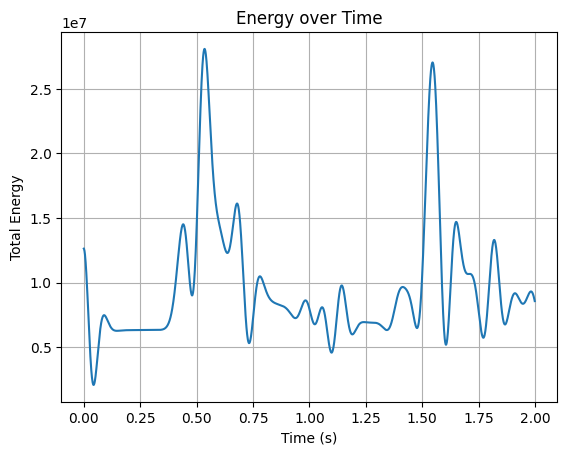

In [4]:
import torch
import plotly.graph_objs as go
import numpy as np
import time

# Simulation parameters
Nx, Ny = 100, 100
Lx, Ly = 1.0, 1.0
dx, dy = Lx / Nx, Ly / Ny
dt = 0.001
T = 2.0
Nt = int(T / dt)
c = 1.0
damping = 0.0005

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.linspace(0, Lx, Nx, device=device)
y = torch.linspace(0, Ly, Ny, device=device)
X, Y = torch.meshgrid(x, y, indexing='ij')

# Initial Gaussian
u0 = torch.exp(-200 * ((X - 0.5)**2 + (Y - 0.5)**2)).to(device)
u1 = u0.clone()

# History
frames = []
energy_history = []

def laplacian(U):
    return (
        -4 * U
        + torch.roll(U, 1, 0) + torch.roll(U, -1, 0)
        + torch.roll(U, 1, 1) + torch.roll(U, -1, 1)
    ) / dx**2

def compute_energy(u_prev, u_curr):
    kinetic = ((u_curr - u_prev) / dt) ** 2
    potential = c**2 * (laplacian(u_curr))**2
    return 0.5 * (kinetic + potential).sum().item()

# Time evolution
for n in range(Nt):
    lap_u1 = laplacian(u1)
    u2 = (
        (2 - damping * dt) * u1 - (1 - damping * dt) * u0
        + c**2 * dt**2 * lap_u1
    )

    # Boundaries
    u2[0, :] = u2[-1, :] = u2[:, 0] = u2[:, -1] = 0.0

    # Save every 100 frames for Plotly
    if n % 100 == 0:
        z = u2.detach().cpu().numpy()
        surface = go.Surface(z=z, colorscale='Viridis')
        frames.append(go.Frame(data=[surface], name=f"t={n*dt:.3f}s"))

    energy_history.append(compute_energy(u0, u1))

    u0, u1 = u1, u2.clone()

# Create initial 3D plot
z0 = u0.detach().cpu().numpy()
surface0 = go.Surface(z=z0, colorscale='Viridis')
layout = go.Layout(
    title="2D Wave Propagation",
    scene=dict(zaxis=dict(range=[-1, 1])),
    updatemenus=[dict(type="buttons", showactive=False,
                      buttons=[dict(label="Play",
                                    method="animate",
                                    args=[None, {"frame": {"duration": 50, "redraw": True},
                                                 "fromcurrent": True}])])]
)

fig = go.Figure(data=[surface0], layout=layout, frames=frames)
fig.show()

# Plot energy
import matplotlib.pyplot as plt
plt.plot(torch.arange(len(energy_history)) * dt, energy_history)
plt.xlabel("Time (s)")
plt.ylabel("Total Energy")
plt.title("Energy over Time")
plt.grid(True)
plt.show()


Use 2D wave equations.

Model energy dissipation or forcing functions.

Implement autodiff-based inverse modeling (using torch.autograd to infer parameters).

Extend to quantum simulations (e.g. Schrödinger equation).
Interactive 3D surface plots using plotly.

Real-time energy graph.

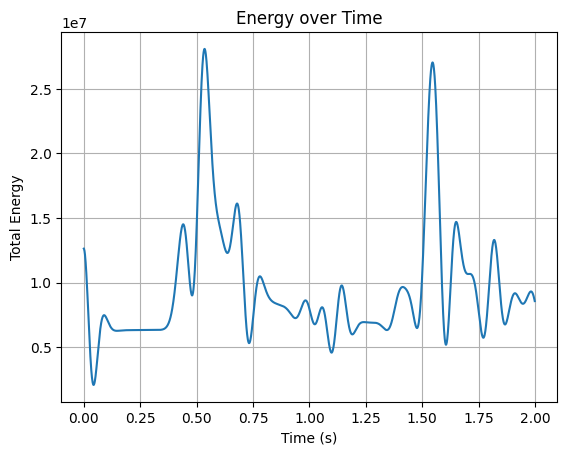

In [5]:
import torch
import plotly.graph_objs as go
import numpy as np
import time

# Simulation parameters
Nx, Ny = 100, 100
Lx, Ly = 1.0, 1.0
dx, dy = Lx / Nx, Ly / Ny
dt = 0.001
T = 2.0
Nt = int(T / dt)
c = 1.0
damping = 0.0005

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.linspace(0, Lx, Nx, device=device)
y = torch.linspace(0, Ly, Ny, device=device)
X, Y = torch.meshgrid(x, y, indexing='ij')

# Initial Gaussian
u0 = torch.exp(-200 * ((X - 0.5)**2 + (Y - 0.5)**2)).to(device)
u1 = u0.clone()

# History
frames = []
energy_history = []

def laplacian(U):
    return (
        -4 * U
        + torch.roll(U, 1, 0) + torch.roll(U, -1, 0)
        + torch.roll(U, 1, 1) + torch.roll(U, -1, 1)
    ) / dx**2

def compute_energy(u_prev, u_curr):
    kinetic = ((u_curr - u_prev) / dt) ** 2
    potential = c**2 * (laplacian(u_curr))**2
    return 0.5 * (kinetic + potential).sum().item()

# Time evolution
for n in range(Nt):
    lap_u1 = laplacian(u1)
    u2 = (
        (2 - damping * dt) * u1 - (1 - damping * dt) * u0
        + c**2 * dt**2 * lap_u1
    )

    # Boundaries
    u2[0, :] = u2[-1, :] = u2[:, 0] = u2[:, -1] = 0.0

    # Save every 100 frames for Plotly
    if n % 100 == 0:
        z = u2.detach().cpu().numpy()
        surface = go.Surface(z=z, colorscale='Viridis')
        frames.append(go.Frame(data=[surface], name=f"t={n*dt:.3f}s"))

    energy_history.append(compute_energy(u0, u1))

    u0, u1 = u1, u2.clone()

# Create initial 3D plot
z0 = u0.detach().cpu().numpy()
surface0 = go.Surface(z=z0, colorscale='Viridis')
layout = go.Layout(
    title="2D Wave Propagation",
    scene=dict(zaxis=dict(range=[-1, 1])),
    updatemenus=[dict(type="buttons", showactive=False,
                      buttons=[dict(label="Play",
                                    method="animate",
                                    args=[None, {"frame": {"duration": 50, "redraw": True},
                                                 "fromcurrent": True}])])]
)

fig = go.Figure(data=[surface0], layout=layout, frames=frames)
fig.show()

# Plot energy
import matplotlib.pyplot as plt
plt.plot(torch.arange(len(energy_history)) * dt, energy_history)
plt.xlabel("Time (s)")
plt.ylabel("Total Energy")
plt.title("Energy over Time")
plt.grid(True)
plt.show()
